In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# Referat 1

# Adaptivne riadenie

In [2]:
def fcn_LTIS(x, t, A, b, u):
    dotx = np.matmul(A, x) + np.matmul(b, u)
    return dotx                                                ### cellE c01 ###

def fcn_simSch2 ( t_start , T_s , finalIndex , sig_r_ext ):

    A_m = np.array([[-1]])
    b_m = np.array([[1]])

    A = np.array([[-0.55]])
    b = np.array([[1]])
    c = np.array([[1]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.array([0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.array([0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0
    print(np.shape(x_log))
    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c, x_0)

    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, 1])
    xf2_log = np.zeros([finalIndex, 1])

    Theta_log = np.zeros([finalIndex, 2])
    # −−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------
        # Referencny model realizovany pomocou riadneho ode solevera
        # Takyto ode solver nemusi byt vzdy dostupny z pohladu implemetnacie riadiaceho systemu

        odeOut = odeint(fcn_LTIS,
                        x_m_log[idx-1,:],
                        timespan,
                        args=(A_m, b_m, sig_r_ext[idx-1,:])
                        )

        x_m_log[idx,:] = odeOut[-1,:]

        # ------------
        odeOut = odeint(fcn_LTIS,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]
        y_log[idx,:] = np.dot(c, x_log[idx,:])

        # -------------------------
        alpha = 0.5

        omega = np.array([sig_r_ext[idx-1,:], y_log[idx-1,:]])
        adaptErr = y_log[idx-1, 0] - x_m_log[idx-1, 0]

        # Tu je numericka integracia realizovana jednoducho sumatorom - treba teda dbat na krok integrovania - teda tu to, co volame periodou vzorkovania
        dxf1 = np.dot(A_m, xf1_log[idx-1,:]) + np.dot(b_m, [omega[0,0]])
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1 * T_s
        dTheta_1 = -alpha * adaptErr * xf1_log[idx-1,:]

        dxf2 = np.matmul(A_m, xf2_log[idx-1,:]) + np.matmul(b_m, [omega[1,0]])
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2 * T_s
        dTheta_2 = -alpha * adaptErr * xf2_log[idx-1,:]

        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)

    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log]

In [3]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 100
sim_T_s = 0.005
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

# Preddefinovane signaly

period_time = 20
period_tab = np.array([
                      [0, 1],
                      [10, -1],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break

sig_r_ext = sig_vysl

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )    

(20001, 1)


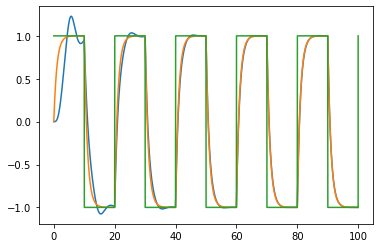

In [4]:
plt.plot(t_log,y_log)
plt.plot(t_log,x_m_log)
plt.plot(t_log,sig_r_ext)

# Moje

In [135]:
import numpy as np
from scipy.integrate import odeint

import sys

# %% ---------------------------------------------------------------------------

#import plantFcns
def plantFcns(x, t, A, b, u):
    dotx = np.dot(A, x) + np.dot(b, u)
    return dotx   


def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    par_L = 161.0
    par_K_0 = -3.86
    par_tau_10 = 5.66
    #par_v = 4.0

    par_K = par_K_0 * (par_v/par_L)
    par_tau_1 = par_tau_10 * (par_L/par_v)

    par_b_0 = par_K/par_tau_1
    par_a_1 = 1.0/par_tau_1

    A = np.array([[0, 1], [0, -par_a_1]])
    b = np.array([[0], [par_b_0]])
    c = np.array([[1], [0]])

    A_m = np.array([[0, 1], [-0.0025, -0.1]])
    b_m = np.array([[0], [0.0025]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.zeros(b_m.shape[0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.zeros(b.shape[0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c.T, x_0.reshape(-1,1))
    
    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, b_m.shape[0]])
    xf2_log = np.zeros([finalIndex, b_m.shape[0]])


    Theta_log = np.zeros([finalIndex, 2])
    Theta_log[0,:] = np.array([-3.8009, -143.6921])*0



    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):
        print(idx)
        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------

        odeOut = odeint(plantFcns,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]

        y_log[idx,:] = np.dot(c.T, x_log[idx,:].reshape(-1,1))

        # -------------------------

        # dxm = np.matmul(A_m, x_m_log[idx-1,:]) + np.matmul(b_m, [sig_r_ext[idx-1,:]])
        dxm = np.add(np.matmul(A_m, x_m_log[idx-1,:].reshape(-1,1)),
                     b_m * sig_r_ext[idx-1,:]
                     )

        x_m_log[idx,:] = x_m_log[idx-1,:] + dxm.reshape(1,-1)[0] * T_s

        # ------------

        alpha_1 = -0.025
        alpha_2 = -25


        # print -x_log[idx-1,1]

        omega = np.array([sig_r_ext[idx-1,:] - y_log[idx-1,:], [-x_log[idx-1,1]]])
        adaptErr = (y_log[idx-1, 0] - x_m_log[idx-1, 0])



        # dxf1 = np.matmul(A_m, xf1_log[idx-1,:]) + np.matmul(b_m, [omega[0,0]])
        dxf1 = np.add(np.matmul(A_m, xf1_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[0,0]
                     )
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1.reshape(1,-1)[0] * T_s
        dTheta_1 = -alpha_1 * adaptErr * np.dot([1, 0], xf1_log[idx-1,:].reshape(-1,1))


        dxf2 = np.add(np.matmul(A_m, xf2_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[1,0]
                     )
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2.reshape(1,-1)[0] * T_s
        dTheta_2 = -alpha_2 * adaptErr * np.dot([1, 0], xf2_log[idx-1,:].reshape(-1,1))


        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)


    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log]

In [136]:
sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
period_tab = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


# %% --------------------------------------------------------------------------

sig_r_ext = sig_vysl

# %% ---------------------------------------------------------------------------

par_v = 6

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165


3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065


5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748


In [128]:
y_log5=y_log

In [130]:
y_log4=y_log

In [132]:
y_log6=y_log

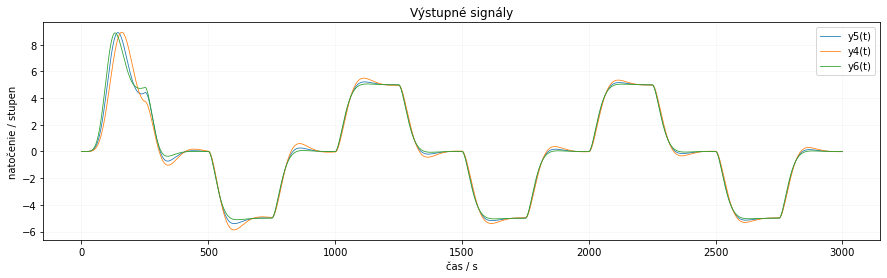

In [134]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,y_log5*180/np.pi,linewidth=0.8)
plt.plot(t_log,y_log4*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log6*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['y5(t)','y4(t)','y6(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('signal3.png')

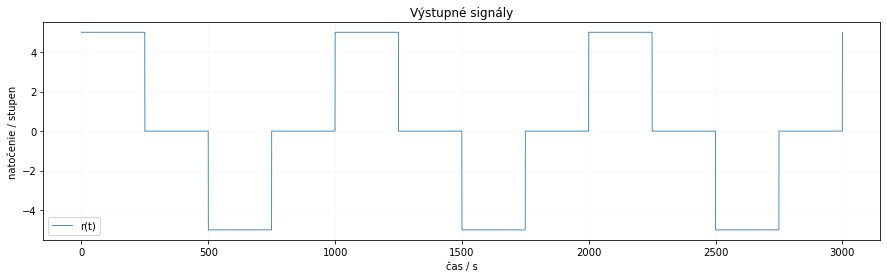

In [124]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi,linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('vstup.png')

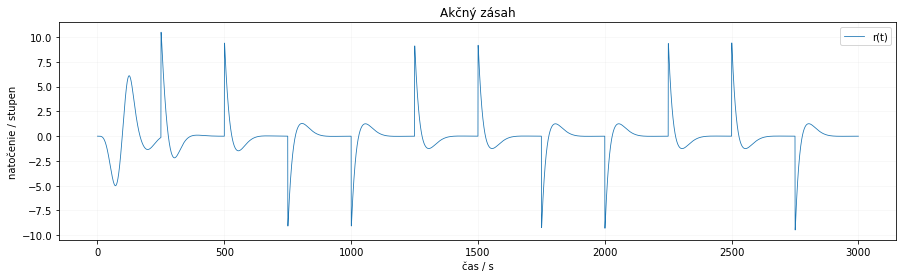

In [121]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,u_log*180/np.pi, linewidth=0.8)
plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Akčný zásah')
plt.grid(alpha=0.1)

plt.savefig('zasah.png')

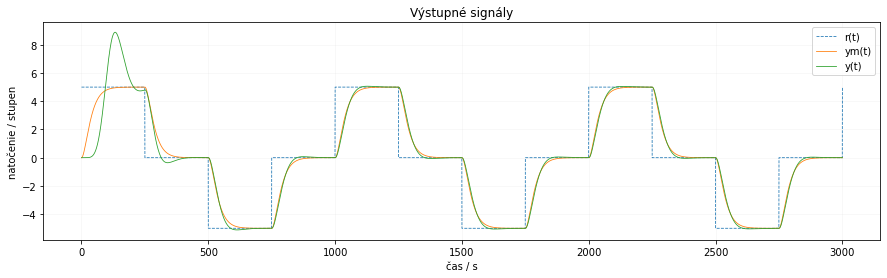

In [122]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('signal.png')

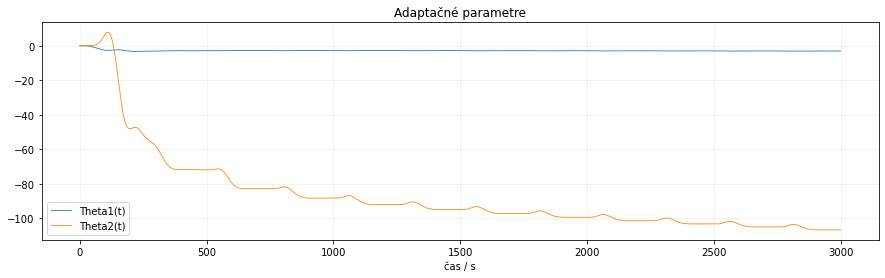

In [117]:
plt.figure(figsize=(15, 4))
plt.plot(t_log, Theta_log, linewidth=0.8)
plt.xlabel('čas / s')
plt.legend(['Theta1(t)','Theta2(t)'])
plt.title('Adaptačné parametre')
plt.grid(alpha=0.2)
plt.savefig('theta.png')

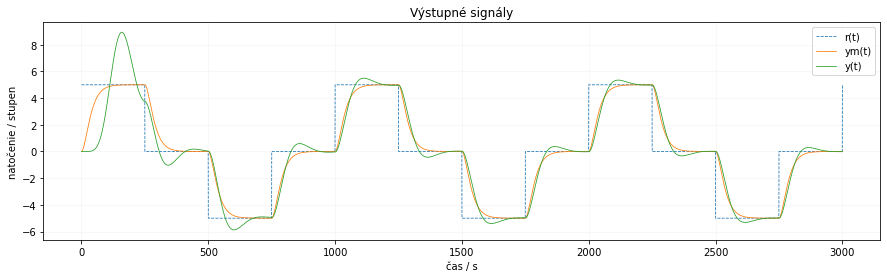

In [125]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('signal.png')